In [11]:
import os
import sys
sys.path.append('/home/kal/TF_models/bin/')
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Must be before importing keras!

import sequence
import train_TFmodel
import eval_TFmodel
import seq_only_gen
import snv_tools

import ucscgenome
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve
from scipy.integrate import trapz

# get the model
#ml = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_regression/test_CTCF')
ml = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_regression/20170920_regression_model/')
pwm = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_classifier/pwm_frozen/')

# get the genome
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

Loading model without Bias layer


In [7]:
# get the snvs from the filtered 1000 genomes set
genomes_path = '/home/kal/TF_models/data/SNVs/1000genomes_SNVs/1000genomes_s7.bed'
snvs = pd.read_table(genomes_path, delimiter=',')
snvs.columns = 'chr position end refAllele altAllele ref_freq alt_freq diff_freq motif TF indiv_TF allelic_ratio'.split()

# get pwm reference distances
distances=list()
pwm_prefpreds=list()
for seq in tqdm(eval_TFmodel.snv_gen(snvs, genome, alt=False)):
    pwm_info = sequence.Sequence(seq).find_pwm() #meme, distances, score
    if sequence.CTCF_memes.index(pwm_info[0])==0:
        distances.append(pwm_info[1])
    else:
        distances.append(255-pwm_info[1]-len(pwm_info[0].seq)) # correct distance if reversed
    pwm_prefpreds.append(pwm_info[2])
    
snvs['rdist'] = np.asarray(distances)
snvs['pwm_prefpreds'] = np.asarray(pwm_prefpreds)


# get pwm alternate distances
distances=list()
pwm_paltpreds=list()
for seq in tqdm(eval_TFmodel.snv_gen(snvs, genome, alt=True)):
    pwm_info = sequence.Sequence(seq).find_pwm() #meme, distances, score
    if sequence.CTCF_memes.index(pwm_info[0])==0:
        distances.append(pwm_info[1])
    else:
        distances.append(255-pwm_info[1]-len(pwm_info[0].seq)) # correct distance if reversed
    pwm_paltpreds.append(pwm_info[2])
    
snvs['adist'] = np.asarray(distances)
snvs['pwm_paltpreds'] = np.asarray(pwm_paltpreds)


# get predicitons
all_refpreds, all_altpreds = ml.predict_snv(snvs, genome)
all_prefpreds, all_paltpreds = pwm.predict_snv(snvs, genome)

# add to the database
snvs['refpreds'] = all_refpreds
snvs['altpreds'] = all_altpreds
snvs['prefpreds'] = all_prefpreds
snvs['paltpreds'] = all_paltpreds

#write out the dataset
snvs.to_csv(genomes_path + '_newpreds', sep='\t', header=None, index=False)

snvs['diffs'] = snvs.refpreds - snvs.altpreds 
snvs['pdiffs'] = snvs['pwm_prefpreds'] - snvs['pwm_paltpreds']

823it [00:00, 1320.13it/s]
823it [00:00, 1318.46it/s]


691it [00:00, 6903.36it/s]

2481


2481it [00:00, 6912.76it/s]
135it [00:00, 1341.81it/s]

1069


1069it [00:00, 1311.19it/s]
1069it [00:00, 1322.12it/s]


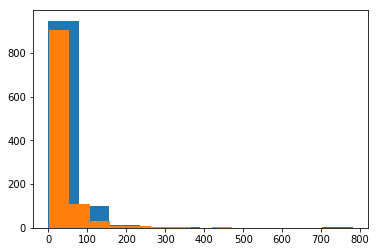

Average counts: 30.293927346429683


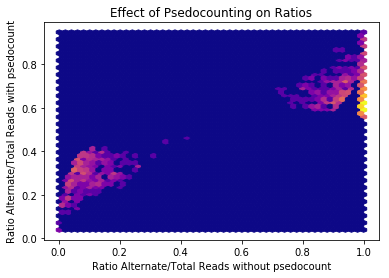

In [18]:
# get the snvs from the 1000 genomes set
genomes_path = '/home/kal/TF_models/data/SNVs/1000genomes_SNVs/1000genomes_s1_sorted.bed'
all_snvs = pd.read_table(genomes_path)
all_snvs.columns = 'chr start end variantID refAllele a c t g motifCount'.split()
raw_snvs = all_snvs[all_snvs.variantID.apply(lambda x: 'CTCF' in x)].copy()
print(len(raw_snvs))

# homozygous merge of features with averaging.
# only if > min_count reads on an allele for each experiment, the snp is the same

allow_zero_refs=True

min_count=1
ref_row = raw_snvs.iloc[0]


allele_to_n = {'a':0, 'c':1, 't':2, 'g':3}
n_to_allele = ['a', 'c', 't', 'g']
# count is the number of reads in a, c, t, g
count = [0,0,0,0]
# exp_count is the number of contributing experiments
exp_count = [0,0,0,0]
filtered_snps = list()
def update_count(count, exp_count, row):
    # generate array from row
    reads = [row['a'], row['c'], row['g'], row['t']]
    refCount = reads[allele_to_n[row['refAllele'].lower()]]
    if (int(refCount) > min_count):
        count[allele_to_n[row.refAllele.lower()]] += refCount
        exp_count[allele_to_n[row.refAllele.lower()]] += 1
    reads[allele_to_n[row['refAllele'].lower()]] = 0
    # case with no alternate
    for altread in reads:
        if altread > min_count:
            altAllele = n_to_allele[reads.index(altread)]
            count[allele_to_n[altAllele.lower()]] += altread
            exp_count[allele_to_n[altAllele.lower()]] += 1 
    return count, exp_count
    
#cycle through
for index, row in tqdm(raw_snvs.iterrows()):
    # at same position?
    if ref_row.start == int(row.start) and ref_row.chr == row.chr:
        update_count(count, exp_count, row)
    else:
        # write out the last bit of data
        for allele in n_to_allele:
            if ref_row['refAllele'].lower() == allele:
                pass
            
            
            elif (count[allele_to_n[allele]] > 0) and (count[allele_to_n[ref_row.refAllele.lower()]] > 0 or allow_zero_refs):           
                # make a new row for each nonzero elem
                if exp_count[allele_to_n[ref_row.refAllele.lower()]] != 0:
                    ref_count = count[allele_to_n[ref_row.refAllele.lower()]] / exp_count[allele_to_n[ref_row.refAllele.lower()]]
                else:
                    ref_count = 0
                alt_count = count[allele_to_n[allele]] / exp_count[allele_to_n[allele]]
                new_row = [ref_row.chr, ref_row.start, ref_row.end, ref_row.refAllele.lower(), allele, ref_count, alt_count]
                filtered_snps.append(new_row)
        # start for the next row
        ref_row = row
        count = [0, 0, 0, 0]
        exp_count = [0, 0, 0, 0]
        update_count(count, exp_count, row)    

columns=['chr', 'start', 'end', 'refAllele',  'altAllele',  'refCount',  'altCount']
snvs = pd.DataFrame(filtered_snps, columns=columns)
snvs['position'] = snvs.start
print(len(snvs))

# get pwm reference distances
distances=list()
pwm_prefpreds=list()
for seq in tqdm(eval_TFmodel.snv_gen(snvs, genome, alt=False)):
    pwm_info = sequence.Sequence(seq).find_pwm() #meme, distances, score
    if sequence.CTCF_memes.index(pwm_info[0])==0:
        distances.append(pwm_info[1])
    else:
        distances.append(255-pwm_info[1]-len(pwm_info[0].seq)) # correct distance if reversed
    pwm_prefpreds.append(pwm_info[2])
    
snvs['rdist'] = np.asarray(distances)
snvs['pwm_prefpreds'] = np.asarray(pwm_prefpreds)


# get pwm alternate distances
distances=list()
pwm_paltpreds=list()
for seq in tqdm(eval_TFmodel.snv_gen(snvs, genome, alt=True)):
    pwm_info = sequence.Sequence(seq).find_pwm() #meme, distances, score
    if sequence.CTCF_memes.index(pwm_info[0])==0:
        distances.append(pwm_info[1])
    else:
        distances.append(255-pwm_info[1]-len(pwm_info[0].seq)) # correct distance if reversed
    pwm_paltpreds.append(pwm_info[2])
    
snvs['adist'] = np.asarray(distances)
snvs['pwm_paltpreds'] = np.asarray(pwm_paltpreds)


# get predicitons
all_refpreds, all_altpreds = ml.predict_snv(snvs, genome)
all_prefpreds, all_paltpreds = pwm.predict_snv(snvs, genome)

# add to the database
snvs['refpreds'] = all_refpreds
snvs['altpreds'] = all_altpreds
snvs['prefpreds'] = all_prefpreds
snvs['paltpreds'] = all_paltpreds

#write out the dataset
snvs.to_csv(genomes_path + '_newpreds', sep='\t', header=None, index=False)

# get mean rc number to use in psedocount normalization
plt.hist(snvs['refCount'])
plt.hist(snvs['altCount'])
plt.show()
average_counts= (sum(snvs['refCount'])+ sum(snvs['altCount']))/(2*len(snvs['refCount']))
print('Average counts: ' + str(average_counts))

# get differences WITH PSEUDOCOUNTS
snvs['old_allelic_ratio'] = [alt/(alt+ref) for alt, ref in zip(snvs.altCount, snvs.refCount)]
snvs['allelic_ratio'] = [(alt+average_counts)/(alt+ref+2*average_counts) for alt, ref in zip(snvs.altCount, snvs.refCount)]
snvs['diffs'] = snvs.altpreds - snvs.refpreds
snvs['pdiffs'] = snvs['pwm_paltpreds']-snvs['pwm_prefpreds']
#snvs['pdiffs'] = snvs.paltpreds - snvs.prefpreds
snvs['ratios'] = [alt/(ref+alt) for ref, alt in zip(snvs.refpreds, snvs.altpreds)]
snvs['pratios'] = [alt/(ref+alt) for ref, alt in zip(snvs.prefpreds, snvs.paltpreds)]

plt.hexbin(snvs['old_allelic_ratio'], snvs['allelic_ratio'], gridsize=50, bins='log', cmap='plasma')
plt.title('Effect of Psedocounting on Ratios')
plt.xlabel('Ratio Alternate/Total Reads without psedocount')
plt.ylabel('Ratio Alternate/Total Reads with psedocount')
plt.show()

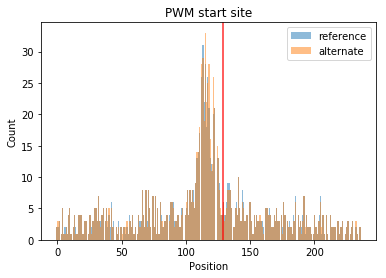

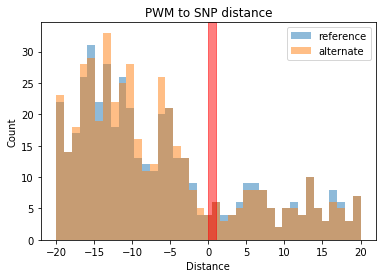

In [19]:
# look at distances
plt.hist(snvs['rdist'], alpha=0.5, bins=256, label='reference')
plt.hist(snvs['adist'], alpha=0.5, bins=256, label='alternate')
plt.axvspan(128, 129, color='red', alpha=0.5)
plt.title('PWM start site')
plt.xlabel('Position')
plt.ylabel('Count')
plt.legend()
plt.show()

bins=256
bins=np.linspace(-20, 20, num=40)
plt.hist(snvs['rdist']-128, alpha=0.5, bins=bins, label='reference')
plt.hist(snvs['adist']-128, alpha=0.5, bins=bins, label='alternate')
plt.axvspan(0, 1,color='red', alpha=0.5)
plt.title('PWM to SNP distance')
plt.xlabel('Distance')
plt.ylabel('Count')
plt.legend()
plt.show()

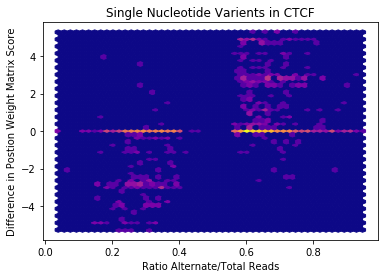

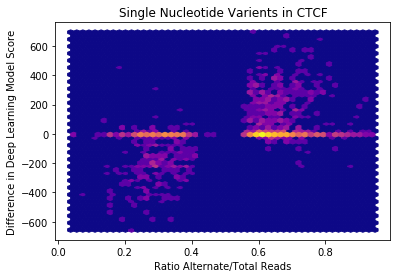

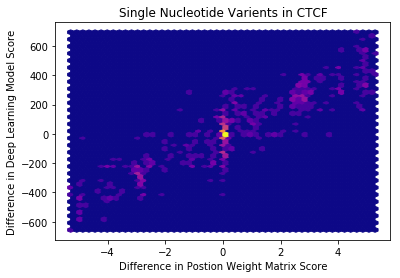

In [20]:
# how well does it predict?
plt.hexbin(snvs['allelic_ratio'], snvs['pdiffs'], gridsize=50, bins='log', cmap='plasma')
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Ratio Alternate/Total Reads')
plt.ylabel('Difference in Postion Weight Matrix Score')
plt.show()

plt.hexbin(snvs['allelic_ratio'], snvs['diffs'], gridsize=50, bins='log', cmap='plasma')
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Ratio Alternate/Total Reads')
plt.ylabel('Difference in Deep Learning Model Score')
plt.show()

plt.hexbin(snvs['pdiffs'], snvs['diffs'], gridsize=50, bins='log', cmap='plasma')
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Difference in Postion Weight Matrix Score')
plt.ylabel('Difference in Deep Learning Model Score')
plt.show()

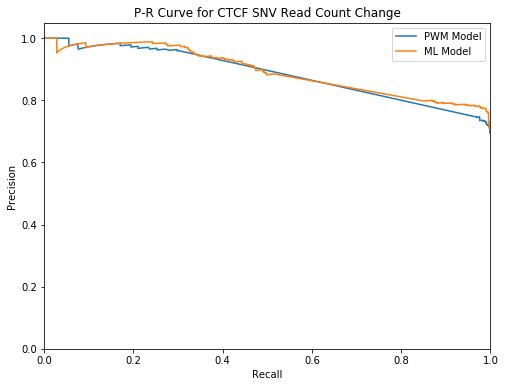

AOC ML: 0.8939549180596025
AOC PWM: 0.8866546428179921


/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in double_scalars
/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:33: RuntimeWarning: divide by zero encountered in double_scalars


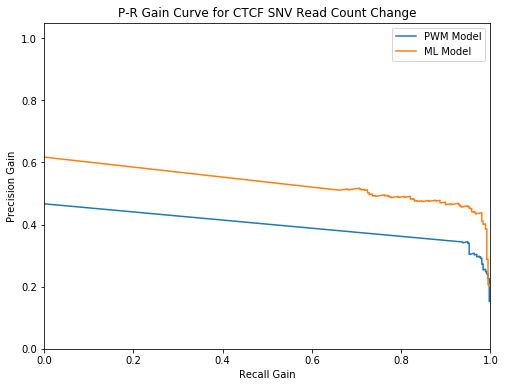

In [21]:
#p-r curve
snvs['diff_label'] = snvs['allelic_ratio'] >= .5

plt.figure(figsize=(8,6))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Curve for CTCF SNV Read Count Change')
plt.xlabel('Recall')
plt.ylabel('Precision')
pwm_p, pwm_r, pwm_t = precision_recall_curve(snvs['diff_label'], snvs['pdiffs'], pos_label=1)
plt.plot(pwm_r, pwm_p, label='PWM Model')
p, r, t = precision_recall_curve(snvs['diff_label'], snvs['diffs'], pos_label=1)
plt.plot(r, p, label='ML Model')
plt.legend()
plt.show()
print('AOC ML: ' + str(- trapz(p,r)))
print('AOC PWM: ' + str(- trapz(pwm_p,pwm_r)))


#p-r gain curve
plt.figure(figsize=(8,6))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Gain Curve for CTCF SNV Read Count Change')
plt.xlabel('Recall Gain')
plt.ylabel('Precision Gain')

prop_pos = sum(snvs['diff_label'])/len(snvs['diff_label'])
pwm_pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in pwm_p]
pwm_rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in pwm_r]
plt.plot(pwm_rgain, pwm_pgain, label='PWM Model')
pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in p]
rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in r]
plt.plot(rgain, pgain, label= 'ML Model')
plt.legend()
plt.show()

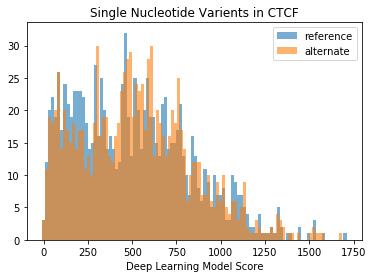

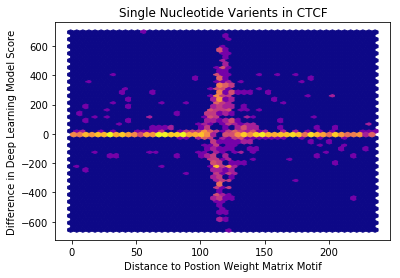

In [22]:
# figure out why there are so many zeros
plt.hist(snvs['refpreds'], bins=100, label='reference', alpha=0.6)
plt.hist(snvs['altpreds'], bins=100, label='alternate',  alpha=0.6)
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Deep Learning Model Score')
plt.legend()
plt.show()

plt.hexbin(snvs['rdist'], snvs['diffs'], gridsize=50, bins='log', cmap='plasma')
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Distance to Postion Weight Matrix Motif')
plt.ylabel('Difference in Deep Learning Model Score')
plt.show()

1069
376


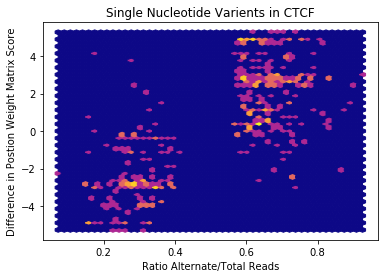

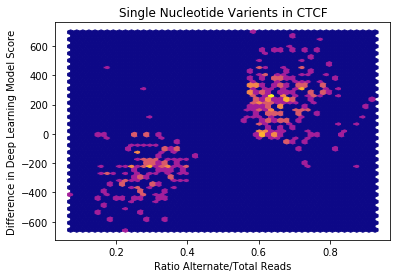

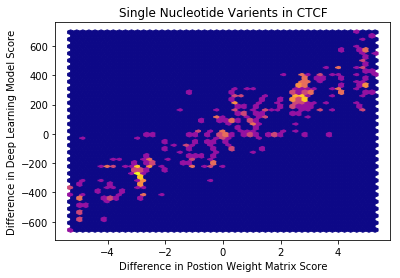

In [23]:
# get only strong pwm signals with mutation in the reference or alternate motif 
# this means distance between 109 and 128
strong_filter = [((r > 108) and (r < 129)) or ((a > 108) and (a < 129)) for r, a in zip(snvs['rdist'], snvs['adist'])]
print(len(snvs))
print(len(snvs[strong_filter]))
plt.hexbin(snvs[strong_filter]['allelic_ratio'], snvs[strong_filter]['pdiffs'], gridsize=50, bins='log', cmap='plasma')
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Ratio Alternate/Total Reads')
plt.ylabel('Difference in Postion Weight Matrix Score')
plt.show()

plt.hexbin(snvs[strong_filter]['allelic_ratio'], snvs[strong_filter]['diffs'], gridsize=50, bins='log', cmap='plasma')
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Ratio Alternate/Total Reads')
plt.ylabel('Difference in Deep Learning Model Score')
plt.show()

plt.hexbin(snvs[strong_filter]['pdiffs'], snvs[strong_filter]['diffs'], gridsize=50, bins='log', cmap='plasma')
plt.title('Single Nucleotide Varients in CTCF')
plt.xlabel('Difference in Postion Weight Matrix Score')
plt.ylabel('Difference in Deep Learning Model Score')
plt.show()

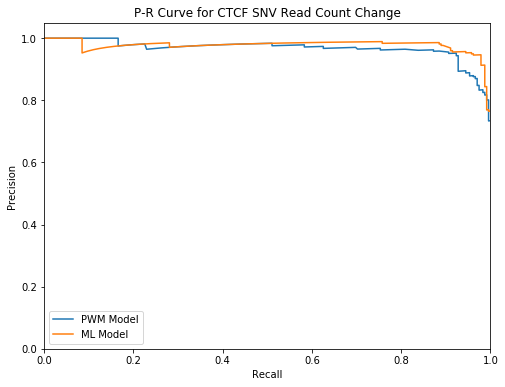

AOC ML: 0.9775805784907446
AOC PWM: 0.9676405683395105


/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in double_scalars
/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: divide by zero encountered in double_scalars


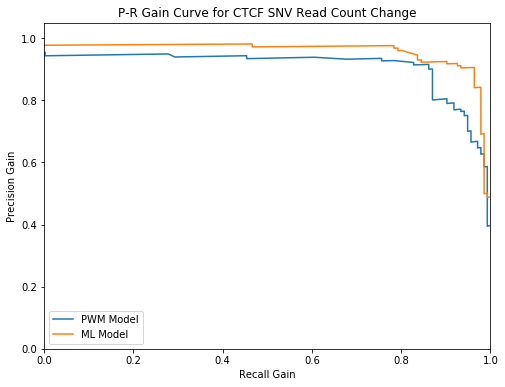

In [24]:
#p-r curve
plt.figure(figsize=(8,6))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Curve for CTCF SNV Read Count Change')
plt.xlabel('Recall')
plt.ylabel('Precision')
pwm_p, pwm_r, pwm_t = precision_recall_curve(snvs[strong_filter]['diff_label'], snvs[strong_filter]['pdiffs'], pos_label=1)
plt.plot(pwm_r, pwm_p, label='PWM Model')
p, r, t = precision_recall_curve(snvs[strong_filter]['diff_label'], snvs[strong_filter]['diffs'], pos_label=1)
plt.plot(r, p, label='ML Model')
plt.legend()
plt.show()
print('AOC ML: ' + str(- trapz(p,r)))
print('AOC PWM: ' + str(- trapz(pwm_p,pwm_r)))


#p-r gain curve
plt.figure(figsize=(8,6))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Gain Curve for CTCF SNV Read Count Change')
plt.xlabel('Recall Gain')
plt.ylabel('Precision Gain')

prop_pos = sum(snvs[strong_filter]['diff_label'])/len(snvs[strong_filter]['diff_label'])
pwm_pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in pwm_p]
pwm_rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in pwm_r]
plt.plot(pwm_rgain, pwm_pgain, label='PWM Model')
pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in p]
rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in r]
plt.plot(rgain, pgain, label= 'ML Model')
plt.legend()
plt.show()


In [25]:
# testing motif scanner
nucs=sequence.encode_to_onehot(genome['chr1'][17036489:17036489+256])
seq =sequence.Sequence(nucs)
print(seq.find_pwm())
ctcf=[np.random.choice(sequence.one_hot_encoder, p=base) for base in sequence.CTCF_memes[0].seq]
nucs[14:14+len(sequence.CTCF_memes[0].seq)]= sequence.encode_to_onehot(np.asarray(ctcf))
seq =sequence.Sequence(nucs)
print(seq.find_pwm())

(Meme() length 19, 211, 3.0343683864991906)
(Meme() length 19, 14, 15.666591527074576)


In [ ]:
snv_tools.bed_sort('/home/kal/TF_models/data/SNVs/1000genomes_SNVs/1000genomes_s1.bed', '/home/kal/TF_models/data/SNVs/1000genomes_SNVs/1000genomes_s1_sorted.bed')

In [ ]:
a = list()
a.append(3)